# AI_Assignment #3
## Clustering
### Mohammad Javad Pesarakloo, SID = 810100103

# Introduction
In this assignment, we are exploring different clustering methods to distinguish similarities between images of different types of flowers.The clustering algorithms we are using are **Kmeans** and **DBScan**.To extract features from images, we are using the pre-trained convolutional neural network model **VGG16** which gives as output a 3-dimensional vector of shape 7*7*512 which we later flatten to decrease complexity of the model.

# Preprocessing and Feature extraction
As mentioned earlier, we are using VGG16 model to extract features from images.Below is a schematic of this model:

![Image Title](image_src/VGG16.png)

## Questions on preprocessing and feature extraction
> 1-why do we extract features?why we are not only reading pixels?
>> answer : In image processing and computer vision, feature extraction is a crucial step because it transforms raw data into a format that is more suitable for machine learning models to process and understand.There are several reasons for which, feature extraction is preferred over just reading pixels:
>>> * Relevant Information: Pixels by themselves do not carry enough meaningful information for complex tasks like object detection or classification. Features like edges, corners, textures, and shapes provide a higher level of abstraction that is more informative.
>>> * Noise Reduction: Feature extraction can help to reduce noise and variability in the data that are not relevant to the task at hand, improving the performance of the model.
>>> * Computational Efficiency: Processing raw pixel data requires significant computational power and memory. Extracting features reduces the computational load, making the process more efficient.
>>> * Generalization: By focusing on features, models can generalize better from the training data to new, unseen data, which is essential for robust machine learning applications.

> 2-methods of feature extraction from images?
>> answer : Here are three methods of feature extraction from images:
>>> * Histogram of Oriented Gradients (HOG): HOG calculates the distribution of gradient orientations within image patches.It captures local shape information and is commonly used for object detection and recognition tasks.
>>> * Scale-Invariant Feature Transform (SIFT): SIFT identifies key points and descriptors that are invariant to scale, rotation, and affine transformations.It works well for matching features across different views of an object.
>>> * Edge Features: Edge features involve detecting and analyzing edges or boundaries in an image.They can be useful for tasks such as object detection, motion detection, image segmentation, and optical character recognition (OCR).

> 3-what preprocessing should be done on images to enter model?
>> answer : As shown in the above picture, the input of VGG model is a 224*224*3 vector in which the 3 is number of channels of each pixel which is already satisfied in extracting but shape of image should be changed to 224*224.

In [1]:
import os
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from sklearn.cluster import KMeans


model = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()

directory = 'flower_images'

features_list = []

for filename in os.listdir(directory):
    if filename.endswith(".png"):
        img_path = os.path.join(directory, filename)
        features = extract_features(img_path, model)
        features_list.append(features)

X = np.array(features_list)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━

In [2]:
X.shape

(210, 25088)

# Clustering
There are different algorithms for clustering.Let's explore kmeans and DBScan and analyze their pros and cons:
## Kmeans
The k-means algorithm is a popular unsupervised machine learning technique used for clustering data.k-means partitions a dataset into K distinct clusters based on feature similarity.The algorithm initializes K centroids randomly and assigns each data point to the nearest centroid, forming clusters.Centroids are recalculated as the mean of all points in a cluster, and points are reassigned.This process repeats until the centroids stabilize and no further changes occur in the assignment of data points.
> pros:
>> * Simplicity: It’s relatively easy to implement and understand.
>> * Efficiency: Scales well to large datasets and guarantees convergence.
>> * Adaptability: Can warm-start the positions of centroids and easily adapts to new examples.
>> * Generalization: Can generalize to clusters of different shapes and sizes.

> cons:
>> * Manual Selection of K: The number of clusters (K) must be chosen manually, which can be challenging.
>> * Initial Sensitivity: The results can be sensitive to the initial random placement of centroids.
>> * Outliers: Centroids can be influenced by outliers, potentially skewing the results.
>> * Equal Variance Assumption: Assumes clusters of approximately equal size, which might not always be the case.

## DBScan
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that identifies clusters in data based on the density of data points.DBSCAN groups data points that are closely packed together, marking as outliers those that lie alone in low-density regions.The algorithm requires two parameters: Eps (the maximum distance between two points for one to be considered as in the neighborhood of the other) and MinPts (the minimum number of points required to form a dense region).It starts by identifying core points (with at least MinPts within Eps distance) and expands clusters from them.Points not reachable from any core points are considered outliers.
> pros:
>> * No Need to Specify Cluster Numbers: Unlike k-means, DBSCAN does not require you to specify the number of clusters in advance.
>> * Flexibility in Shape: It can find clusters of arbitrary shapes, not just spherical ones like k-means.
>> * Robust to Outliers: DBSCAN is less affected by noise and outliers because it classifies them as non-core points.

> cons:
>> * Parameter Sensitivity: Choosing the right Eps and MinPts can be difficult without domain knowledge.
>> * Variable Density: Struggles with clusters of varying densities.
>> * Border Points: Can be confused by border points that are reachable by two clusters.


We start this section by applying kmeans algorithm to cluster images.
## Finding Optimal K
To find optimal K for kmeans algorithm, we use elbow method:

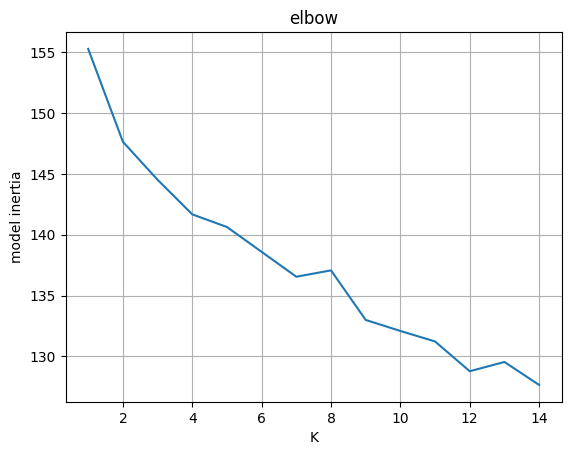

In [7]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
X = normalize(X)
inertias = []
for k in range(1, 15):
    model = KMeans(n_clusters=k)
    model.fit(X)
    inertias.append(model.inertia_)

plt.figure()
plt.plot(np.arange(1, 15), inertias)
plt.xlabel('K')
plt.ylabel('model inertia')
plt.title('elbow')
plt.grid()

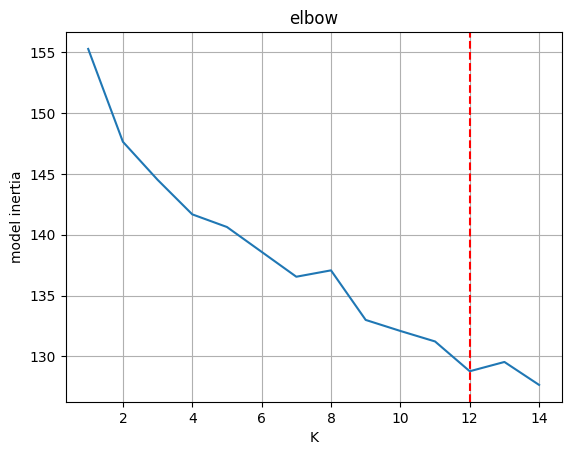

In [8]:
plt.figure()
plt.plot(np.arange(1, 15), inertias)
plt.axvline(x=12, color='red', linestyle = '--')
plt.xlabel('K')
plt.ylabel('model inertia')
plt.title('elbow')
plt.grid()

as the above elbow plot suggests, the optimal k is 12.Now we need to evaluate the accuracy of the model.
## Evalutaion
There are some metrics to evaluate accuracy of clustering algorithms.Here we explain **homogeneity** and **silhouette** scores.
### homogeneity
A perfectly homogeneous clustering is one where each cluster has data-points belonging to the same class label. Homogeneity describes the closeness of the clustering algorithm to this perfection.
### silhouette
The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

To calculate this metrics, we use built in functions of sklearn library.As explained above, homogeneity has to do something with class labels.so we first need to have true labels of the classes.We obtain true labels by reading from csv file.

In [4]:
import pandas as pd
df = pd.read_csv('flower_images/flower_labels.csv')
trueLabels = df.iloc[:, -1].to_numpy().flatten()
trueLabels.shape

(210,)

In [9]:
from sklearn.metrics.cluster import homogeneity_score,silhouette_score
model = KMeans(n_clusters=12)
model.fit(X)
print("homogeneity_score : ", homogeneity_score(trueLabels, model.labels_))
print("silhouette_score : ", silhouette_score(X, model.labels_))

homogeneity_score :  0.5986148520297142
silhouette_score :  0.016879197


As we see above, we got a good homogeneity but got very low silhouette_score which means classes are not well seperated.This makes perfect sense because we have 25088 dimensions for each image.To fine tune the silhouette_score we need to reduce dimensions of the feature space.

## Dimensionality Reduction
To reduce dimensions of feature space, we use **PCA** method.
### PCA
Principal Component Analysis (PCA) is a statistical technique used for dimensionality reduction in data analysis.PCA reduces the number of variables in a dataset while preserving as much information as possible. This is done by transforming the original variables into a new set of uncorrelated variables called principal components.These are the directions in the data that maximize variance when projected onto them. The first principal component captures the most variance, the second captures the second most, and so on.PCA starts by computing the covariance matrix of the data to understand the relationships between different variables.The eigenvectors of the covariance matrix are the principal components, and the eigenvalues represent the amount of variance captured by each principal component.The original data is then projected onto these principal components to transform it into a new coordinate system with reduced dimensions.

In [10]:
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(X)
X_pca.shape

(210, 2)

Now that feature space is 2 dimensional, we can easily visualize them:

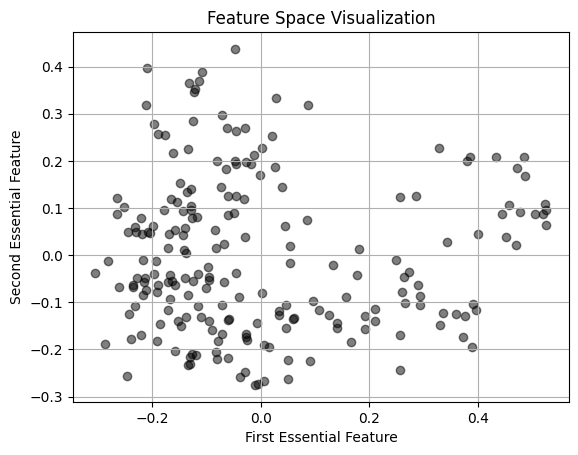

In [11]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, color = 'black')
plt.xlabel("First Essential Feature")
plt.ylabel("Second Essential Feature")
plt.title("Feature Space Visualization")
plt.grid()

Now that we have decreased number of dimensions, we can do clustering algorithm again to see whether it's better or not

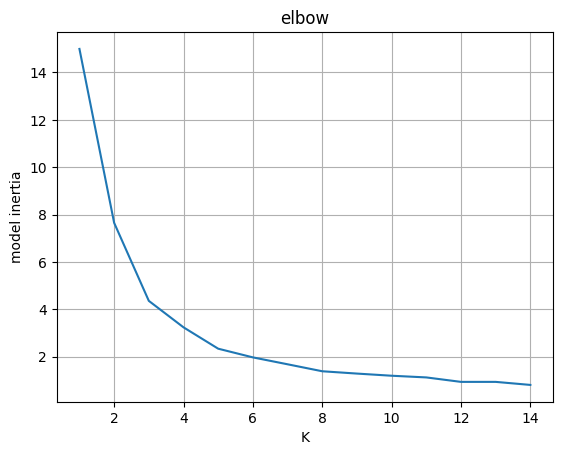

In [12]:
inertias = []
for k in range(1, 15):
    model = KMeans(n_clusters=k)
    model.fit(X_pca)
    inertias.append(model.inertia_)

plt.figure()
plt.plot(np.arange(1, 15), inertias)
plt.xlabel('K')
plt.ylabel('model inertia')
plt.title('elbow')
plt.grid()

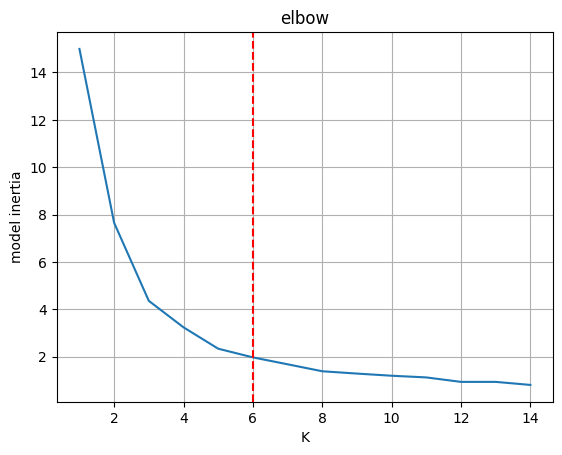

In [13]:
plt.figure()
plt.plot(np.arange(1, 15), inertias)
plt.axvline(x=6, color='red', linestyle = '--')
plt.xlabel('K')
plt.ylabel('model inertia')
plt.title('elbow')
plt.grid()

As the above plot suggests, an optimal K can be 7.If we get higher k, we will get better homogeneity score but that's a result of **overfitting** and results in low silhouette score. 

In [14]:
model = KMeans(n_clusters=6)
model.fit(X_pca)
print("homogeneity_score : ", homogeneity_score(trueLabels, model.labels_))
print("silhouette_score : ", silhouette_score(X_pca, model.labels_))

homogeneity_score :  0.4379161922997044
silhouette_score :  0.40295357


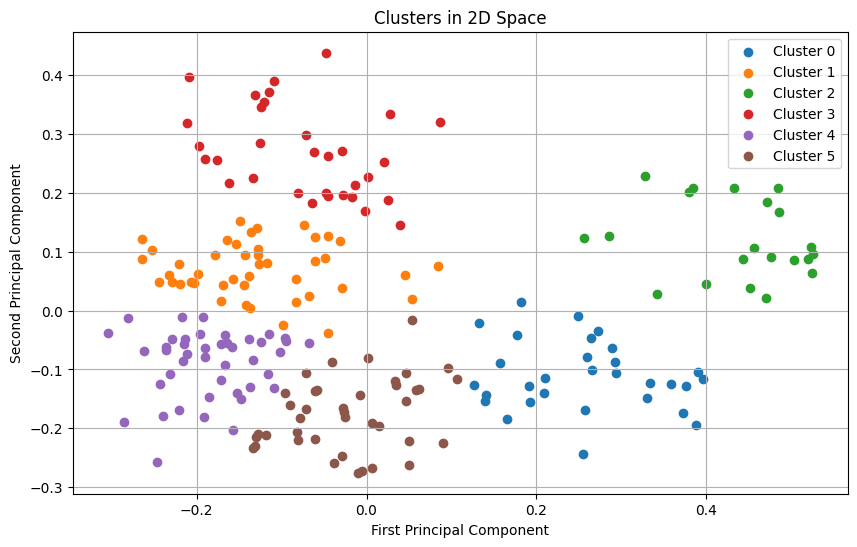

In [15]:
labels = model.predict(X_pca)

plt.figure(figsize=(10, 6))
for label in np.unique(labels):
    plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1], label=f'Cluster {label}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clusters in 2D Space')
plt.grid()
plt.legend()
plt.show()

As shown above, we got much better silhouette score after dimensionality reduction.Now let's train the model on a DBScan model.At first we need to find optimal **eps** and **min_samples** for the model:

In [16]:
normalized_X_pca = normalize(X_pca)
distances = np.empty((210, 210), dtype=float)
for i in range(210):
    for j in range(210):
        dist = np.sqrt((normalized_X_pca[i][0] - normalized_X_pca[j][0])**2 + (normalized_X_pca[i][1] - normalized_X_pca[j][1])**2)
        distances[i][j] = dist
        distances[j][i] = dist
distances = np.sort(distances)
k = 4
k_th_nearest_neighbor = distances[:, 4].flatten()
k_th_nearest_neighbor.shape

(210,)

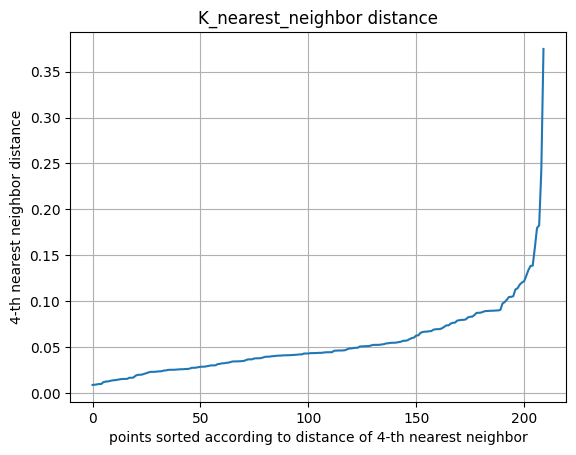

In [17]:
plt.plot(np.sort(k_th_nearest_neighbor))
plt.title('K_nearest_neighbor distance')
plt.xlabel('points sorted according to distance of 4-th nearest neighbor')
plt.ylabel('4-th nearest neighbor distance')
plt.grid()

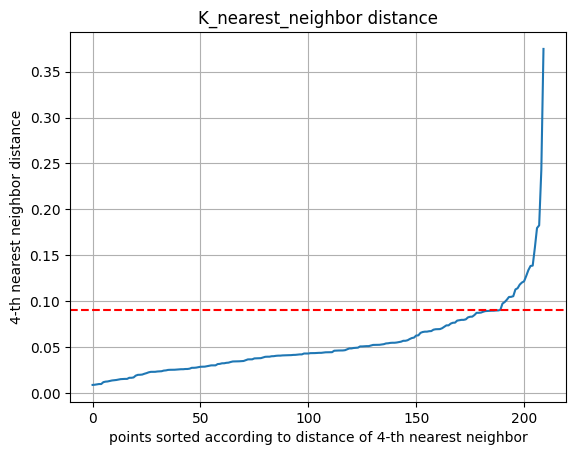

In [18]:
plt.plot(np.sort(k_th_nearest_neighbor))
plt.title('K_nearest_neighbor distance')
plt.xlabel('points sorted according to distance of 4-th nearest neighbor')
plt.ylabel('4-th nearest neighbor distance')
plt.grid()
plt.axhline(y = 0.09, color = 'red', linestyle='--')

As the above plot suggests, an optimal eps can be 0.8.Let's train the model:

In [19]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.08, min_samples=4)
model.fit(normalized_X_pca)
print("homogeneity_score : ", homogeneity_score(trueLabels, model.labels_))
print("silhouette_score : ", silhouette_score(normalized_X_pca, model.labels_))

homogeneity_score :  0.45820601985900705
silhouette_score :  0.52241504


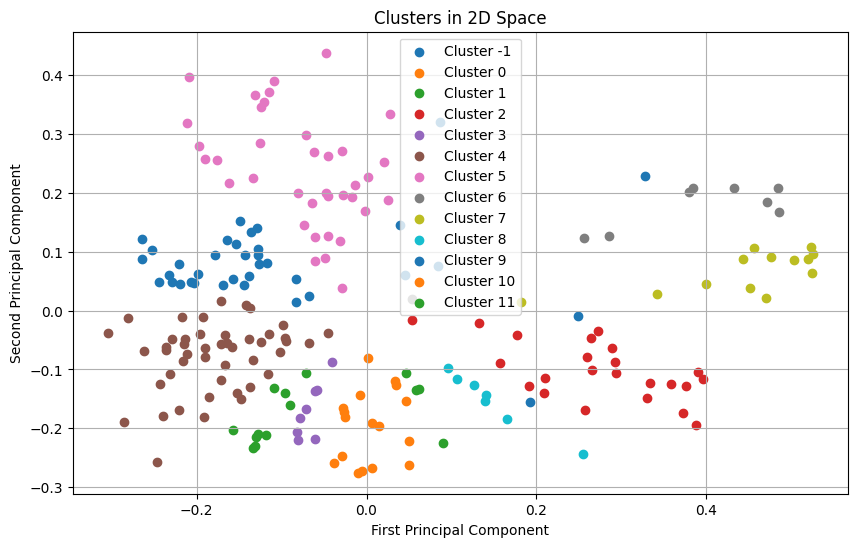

In [20]:
labels = model.fit_predict(normalized_X_pca)

plt.figure(figsize=(10, 6))
for label in np.unique(labels):
    plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1], label=f'Cluster {label}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clusters in 2D Space')
plt.grid()
plt.legend()
plt.show()